# <b style='color:magenta;'> SVM </b>

* Este Jupyter tem como função treinar um `SVM` com os melhores parametros determinados por um `RandomSearch`.



---

Bibliotecas/Módulos

In [20]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, matthews_corrcoef, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC

Configurações dos logs

In [2]:
logger = logging.getLogger("SVM")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [3]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

---

## Preparando os dados

In [4]:
df = pd.read_csv("dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.csv")

In [5]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,label
2798,-4,-2,-1,3,7,3,-1,-4,0,-1,...,-7,2,3,1,-1,3,1,3,1,0


Verificando tamanho do dataset

In [6]:
len(df)

25200

Verificando a quantidade de colunas originais

In [7]:
len(df.columns)

2001

* Seleção da variável target e das features

In [8]:
y = df["label"]

In [9]:
df = df.drop(["label"], axis=1)

#### PCA
Aplicando o PCA para reduzir a dimensão dos dados.

In [10]:
pca = PCA(n_components=1000)

In [11]:
pca.fit(df)

PCA(n_components=1000)

In [12]:
%%time

pca_samples = pca.transform(df)

CPU times: user 22.1 s, sys: 13.5 s, total: 35.5 s
Wall time: 2.78 s


In [13]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-35.068197,23.928768,1.186254,-151.129527,-42.556784,-148.023683,-53.831397,-28.461750,-41.857889,-104.510884,...,47.893167,-16.741126,21.179058,-19.331882,42.672884,-3.448163,36.791325,10.120571,-2.685486,-19.676864
1,-69.680457,36.845880,47.351802,-121.842658,-24.717552,-113.801059,-37.514149,-47.755131,-13.947044,-92.122796,...,57.167758,-11.087775,6.641429,7.293471,16.534226,12.509047,28.392782,6.646068,7.767828,-0.369534
2,-94.676600,38.038653,98.432548,-103.621516,-10.274245,-71.540178,-15.104704,-53.717266,24.066586,-97.600882,...,57.186565,8.766892,-0.602509,14.884400,0.432217,25.030480,23.320101,12.472583,19.476928,12.416552
3,-115.288910,36.334428,137.247898,-70.874058,-8.118221,-44.962368,-3.156064,-64.584880,46.295866,-89.627326,...,67.249950,10.818723,-0.743260,22.758232,-20.553292,28.639392,1.748952,17.537287,15.396282,17.147517
4,-111.539509,45.575378,158.235942,-48.798876,-3.696119,-8.481742,11.270159,-71.759108,48.659401,-69.601917,...,66.318724,16.091896,4.045071,31.212821,-28.886453,34.732989,2.786809,8.053313,12.388258,15.002720


In [14]:
len(ps)

25200

In [15]:
len(ps.columns)

1000

In [16]:
X = ps

Separando os dados em dados de treino e teste

In [17]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

---

## Treinamento

### RandomSearch

Parametros do modelo escolhidos para otimização

In [18]:
# values = {'C':[0.1,1,10,100,100], 'kernel':['rbf', 'linear', 'poly', 'sigmoid', 'precomputed']}
values = {'C':[1, 10, 100], 'kernel':['rbf', 'sigmoid', 'poly']}

In [19]:
clf = SVC()

In [20]:
def best_params(values: dict, clf: 'classificador', x_treino: np.array, x_teste: np.array, y_treino: np.array, y_teste: np.array) -> list:
    '''
        Instancia um classificador de busca e procura os melhores parâmetros para o modelo.
        
        Params
        ------
        :values: parametros a serem testados
        :clf: instancia do classificador desejado
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
        
        Return
        ------
        :best_params: lista com os melhores parametros
    '''
    
    logger.info('Instanciando SVM')
    random_clf = RandomizedSearchCV(clf, param_distributions=values, n_iter=200, verbose=10)
    
    logger.info('Treinando SVM')
    random_clf.fit(x_treino, y_treino)
  
    logger.info('Parametros SVM')
    print(RED, random_clf.get_params())
    
    logger.info('Best Params SVM')
    best_params = random_clf.best_params_
    print(BLUE, best_params)
    
    return best_params

In [21]:
%%time

try:
    best = best_params(values, clf, x_treino, x_teste, y_treino, y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Busca finalizada')

SVM - INFO - [+] ------- Instanciando SVM -------
SVM - INFO - [+] ------- Treinando SVM -------
/home/saraselis/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 9 is smaller than n_iter=200. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START C=1, kernel=rbf.............................................
[CV 1/5; 1/9] END ..............C=1, kernel=rbf;, score=0.726 total time= 4.2min
[CV 2/5; 1/9] START C=1, kernel=rbf.............................................
[CV 2/5; 1/9] END ..............C=1, kernel=rbf;, score=0.727 total time= 3.6min
[CV 3/5; 1/9] START C=1, kernel=rbf.............................................
[CV 3/5; 1/9] END ..............C=1, kernel=rbf;, score=0.735 total time= 3.7min
[CV 4/5; 1/9] START C=1, kernel=rbf.............................................
[CV 4/5; 1/9] END ..............C=1, kernel=rbf;, score=0.729 total time= 3.6min
[CV 5/5; 1/9] START C=1, kernel=rbf.............................................
[CV 5/5; 1/9] END ..............C=1, kernel=rbf;, score=0.736 total time= 3.6min
[CV 1/5; 2/9] START C=1, kernel=sigmoid.........................................
[CV 1/5; 2/9] END ..........C=1, kernel=sigmoid;,

SVM - INFO - [+] ------- Parametros SVM -------
SVM - INFO - [+] ------- Best Params SVM -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Busca finalizada -------


 {'cv': None, 'error_score': nan, 'estimator__C': 1.0, 'estimator__break_ties': False, 'estimator__cache_size': 200, 'estimator__class_weight': None, 'estimator__coef0': 0.0, 'estimator__decision_function_shape': 'ovr', 'estimator__degree': 3, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf', 'estimator__max_iter': -1, 'estimator__probability': False, 'estimator__random_state': None, 'estimator__shrinking': True, 'estimator__tol': 0.001, 'estimator__verbose': False, 'estimator': SVC(), 'n_iter': 200, 'n_jobs': None, 'param_distributions': {'C': [1, 10, 100], 'kernel': ['rbf', 'sigmoid', 'poly']}, 'pre_dispatch': '2*n_jobs', 'random_state': None, 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 10}
 {'kernel': 'rbf', 'C': 1}
CPU times: user 2h 29min 41s, sys: 2.64 s, total: 2h 29min 43s
Wall time: 2h 29min 43s


Melhores parâmetros:

In [22]:
best

{'kernel': 'rbf', 'C': 1}

{'kernel': 'rbf', 'C': 1}

----

### SVM

Treinando o modelo com os melhore parametros

In [18]:
def classificador(x_treino: np.array, y_treino: np.array, x_teste: np.array, y_teste: np.array):
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :RF: Modelo SVM treinado
        :resultados (matrix): métricas
    '''
    
    logger.info('Instanciando SVM')
    SVM = SVC(kernel = 'rbf', C= 1)
    
    logger.info('Treinando SVM')
    SVM.fit(x_treino, y_treino)
    
    logger.info('Predict')
    categorias = SVM.predict(x_teste)
    
    logger.info('Métricas: \n \n')
    
    logger.info('Roc')
    roc = roc_auc_score(y_teste, categorias)
    print(OKBLUE, "Roc \n" + str(roc) + "\n")
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias)
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
       
    return SVM, resultados

---

#### SVM

Treinando com os melhores parametros

SVM - INFO - [+] ------- Instanciando SVM -------
SVM - INFO - [+] ------- Treinando SVM -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Métricas: 
 
 -------
SVM - INFO - [+] ------- Roc -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


 Roc 
0.7273044074731717

 Acc 
0.7271825396825397

 Mcc 
0.4776347748522328

 F1 
0.6779105176856406

 Class Report 
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      2518
           1       0.83      0.57      0.68      2522

    accuracy                           0.73      5040
   macro avg       0.75      0.73      0.72      5040
weighted avg       0.75      0.73      0.72      5040


CPU times: user 9min 16s, sys: 212 ms, total: 9min 17s
Wall time: 9min 20s


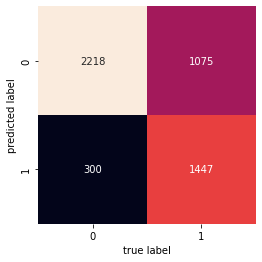

In [21]:
%%time

try:
    SVM, resultados = classificador(x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)
    
else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

---

#### Exportando modelo

In [22]:
pkl.dump(SVM, open('modelos/SVM_dados_FEM_MAS_10_voluntarios_s_semanas_15_sinais_noout.pkl', 'wb'))